In [1]:
from lale.lib.lale import ConcatFeatures
from lale.lib.lale import NoOp
from lale.lib.sklearn import KNeighborsClassifier
from lale.lib.sklearn import LogisticRegression
from lale.lib.sklearn import Nystroem
from lale.lib.sklearn import PCA
from lale.operators import make_union, make_pipeline, make_choice
from sklearn.datasets import load_iris
from lale.helpers import assert_raises, assert_warns
from lale.helpers import to_graphviz
from lale.helpers import println_pos
from jsonschema import ValidationError
iris = load_iris()

In [2]:
abc = PCA()
print(abc)

PCA


In [3]:
abc.fit(iris.data)
with assert_warns(DeprecationWarning):
    abc.transform(iris.data)

{error: 'The `transform` method is deprecated on a trainable operator, because the
    learned coefficients could be accidentally overwritten by retraining. Call `transform`
    on the trained operator returned by `fit` instead.'}


In [4]:
trained_pca = abc.fit(iris.data)
transformed_data = trained_pca.transform(iris.data)

{error: '''PlannedPipeline'' object has no attribute ''fit'''}


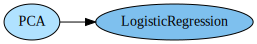

In [5]:
pipeline = abc >> LogisticRegression
#It is a Planned pipeline as one of the operators is not Trainable and hence can't be trained
with assert_raises(AttributeError):
    pipeline.fit(iris.data)
to_graphviz(pipeline)

In [6]:
#configure will make sure it is consistent in the number of operators and type of operator impls
with assert_raises(ValueError):
    trainable_pipeline = pipeline.configure([abc, KNeighborsClassifier])

{error: Please make sure that you pass a list of trainable individual operators (1th
    element is incompatible)}


In [7]:
#The operators have to be trainable
with assert_raises(ValueError):
    trainable_pipeline = pipeline.configure([abc, LogisticRegression])

{error: Please make sure that you pass a list of trainable individual operators (1th
    element is incompatible)}


In [8]:
#Configure an individual operator
print(LogisticRegression.hyperparam_defaults())
lr = LogisticRegression.configure(penalty = LogisticRegression.penalty.l1)
print(lr.get_params_set_by_user())

{'solver': 'liblinear', 'penalty': 'l2', 'dual': False, 'C': 1.0, 'tol': 0.0001, 'fit_intercept': True, 'intercept_scaling': 1.0, 'class_weight': None, 'random_state': None, 'max_iter': 100, 'multi_class': 'auto', 'verbose': 0, 'warm_start': False, 'n_jobs': None}
{'penalty': 'l1'}


{error: "'y' is a required property\n\nFailed validating 'required' in schema:\n \
    \   {'$schema': 'http://json-schema.org/draft-04/schema#',\n     'additionalProperties':\
    \ False,\n     'description': 'Input data schema for training.',\n     'properties':\
    \ {'X': {'description': 'Features; the outer array is '\n                    \
    \                     'over samples.',\n                          'items': {'items':\
    \ {'type': 'number'},\n                                    'type': 'array'},\n\
    \                          'type': 'array'},\n                    'y': {'description':\
    \ 'Target class labels; the array '\n                                        \
    \ 'is over samples.',\n                          'items': {'type': 'number'},\n\
    \                          'type': 'array'}},\n     'required': ['X', 'y'],\n\
    \     'type': 'object'}\n\nOn instance:\n    {'X': [[-2.684125625969537,\n   \
    \         0.3193972465851002,\n            -0.

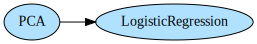

In [9]:
#Configure a pipeline and train it
trainable_pipeline = pipeline.configure([abc, lr])
with assert_raises(ValidationError):
    trainable_pipeline.fit(iris.data)
trainable_pipeline.fit(iris.data, iris.target)
to_graphviz(trainable_pipeline)

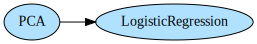

In [10]:
#Different way of creating a trainable pipeline
trainable_pipeline = abc >> LogisticRegression()
trainable_pipeline.fit(iris.data, iris.target)
to_graphviz(trainable_pipeline)

In [11]:
with assert_warns(DeprecationWarning):
    trainable_pipeline.predict(iris.data)

{error: 'The `predict` method is deprecated on a trainable operator, because the learned
    coefficients could be accidentally overwritten by retraining. Call `predict` on
    the trained operator returned by `fit` instead.'}


[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 2 2 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 2 2 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 1 2 2 2 2
 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


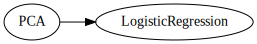

In [12]:
trained_pipeline = trainable_pipeline.fit(iris.data, iris.target)
print(trained_pipeline.predict(iris.data))
to_graphviz(trained_pipeline)

In [13]:
#Test ConcatFeatures
pca = PCA(n_components=3)
nys = Nystroem(n_components=10)
concat = ConcatFeatures()
lr = LogisticRegression(random_state=42, C=0.1)

In [14]:
trainable = (pca & nys) >> concat >> lr
from lale.helpers import print_yaml
print_yaml('trainable', trainable.to_json())

trainable:
  class: lale.operators.TrainablePipeline
  edges:
  - [0, 2]
  - [1, 2]
  - [2, 3]
  state: trainable
  steps:
  - class: lale.lib.sklearn.pca.PCAImpl
    hyperparams: {n_components: 3}
    operator: PCA
    state: trainable
  - class: lale.lib.sklearn.nystroem.NystroemImpl
    hyperparams: {n_components: 10}
    operator: Nystroem
    state: trainable
  - class: lale.lib.lale.concat_features.ConcatFeaturesImpl
    hyperparams: {}
    operator: ConcatFeatures
    state: trained
  - class: lale.lib.sklearn.logistic_regression.LogisticRegressionImpl
    hyperparams: {C: 0.1, random_state: 42}
    operator: LogisticRegression
    state: trainable


In [15]:
import sklearn.datasets
from lale.helpers import cross_val_score
digits = sklearn.datasets.load_digits()
X, y = sklearn.utils.shuffle(digits.data, digits.target, random_state=42)
cv_results = cross_val_score(trainable, X, y)
cv_results = ['{0:.1%}'.format(score) for score in cv_results]
print("Accuracy scores during cross validation: {}".format(cv_results))

Accuracy scores during cross validation: ['67.0%', '64.1%', '65.7%', '65.5%', '63.4%']


In [16]:
from lale.lib.lale import HyperoptClassifier

notebook cell [17] line 2: 2019-06-25_19-12-36 before training HyperoptClassifier
notebook cell [17] line 4: 2019-06-25_19-13-26 after training HyperoptClassifier


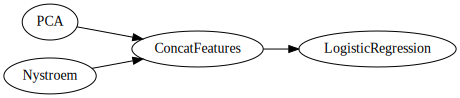

In [17]:
optimizer = HyperoptClassifier(trainable, max_evals=1)
println_pos('before training HyperoptClassifier')
trained = optimizer.fit(X, y)
println_pos('after training HyperoptClassifier')
to_graphviz(trained)

In [18]:
trainable = make_pipeline(make_union(pca, nys), lr)

In [19]:
trained_pipeline = trainable.fit(X, y)

In [20]:
#test OperatorChoice
kernel_tfm_or_not =  NoOp | Nystroem
tfm = PCA
clf = make_choice(LogisticRegression, KNeighborsClassifier)

In [21]:
optimizable = kernel_tfm_or_not >>  clf
print_yaml('optimizable', optimizable.to_json())

optimizable:
  class: lale.operators.PlannedPipeline
  edges:
  - [0, 1]
  state: planned
  steps:
  - class: lale.operators.OperatorChoice
    operator: NoOp | Nystroem
    state: planned
    steps:
    - class: lale.lib.lale.no_op.NoOpImpl
      hyperparams: {}
      operator: NoOp
      state: trained
    - {class: lale.lib.sklearn.nystroem.NystroemImpl, documentation_url: 'https://scikit-learn.org/stable/modules/generated/sklearn.kernel_approximation.Nystroem.html',
      operator: Nystroem, state: planned}
  - class: lale.operators.OperatorChoice
    operator: LogisticRegression | KNeighborsClassifier
    state: planned
    steps:
    - {class: lale.lib.sklearn.logistic_regression.LogisticRegressionImpl, documentation_url: 'http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html',
      operator: LogisticRegression, state: planned}
    - {class: lale.lib.sklearn.k_neighbors_classifier.KNeighborsClassifierImpl, documentation_url: 'https://sciki

In [22]:
#The name() method returns the name of the PlannedIndividualOp that gets created using make_operator, 
#also used in import. It uses the helpers.assignee_name to figure out the name
#This name of the operators is currently used to find out the location of the yaml files, so may be make_operator is 
#not to be exposed to end users (and only to developers) i.e. a singleton PlannedIndividualOp and obtained only by import?
print(abc.name())

PCA


notebook cell [23] line 2: 2019-06-25_19-13-33 before training HyperoptClassifier
notebook cell [23] line 4: 2019-06-25_19-16-15 after training HyperoptClassifier


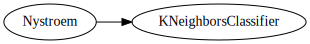

In [23]:
optimizer = HyperoptClassifier(optimizable, max_evals=2)
println_pos('before training HyperoptClassifier')
trained = optimizer.fit(X, y)
println_pos('after training HyperoptClassifier')
to_graphviz(trained)

In [24]:
print_yaml('trained', trained.to_json())

trained:
  class: lale.operators.TrainedPipeline
  edges:
  - [0, 1]
  state: trained
  steps:
  - class: lale.lib.sklearn.nystroem.NystroemImpl
    hyperparams: {coef0: null, degree: null, gamma: 0.5524391372872689, kernel: polynomial,
      kernel_params: null, n_components: 210, random_state: null}
    operator: Nystroem
    state: trained
  - class: lale.lib.sklearn.k_neighbors_classifier.KNeighborsClassifierImpl
    hyperparams: {algorithm: kd_tree, leaf_size: 30, metric: minkowski, metric_params: null,
      n_jobs: null, n_neighbors: 70, p: 2, weights: distance}
    operator: KNeighborsClassifier
    state: trained


#### Text classification pipeline with pre-trained encoding

In [25]:
from lale.lib.pytorch.bert_pretrained_encoder import BertPretrainedEncoder
bert = BertPretrainedEncoder()
type(bert)

Better speed can be achieved with apex installed from https://www.github.com/nvidia/apex.


lale.operators.TrainedIndividualOp

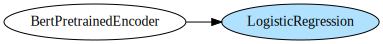

In [26]:
text_clf = BertPretrainedEncoder() >> LogisticRegression()
to_graphviz(text_clf)

In [27]:
from lale.datasets import load_movie_review
X, y = load_movie_review()
X = X[1:30]
y = y[1:30]

In [28]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, make_scorer
cross_val_score(text_clf, X, y, cv=2, scoring = make_scorer(accuracy_score))

array([0.6       , 0.57142857])

In [29]:
text_clf_trained = text_clf.fit(X, y)

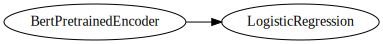

In [30]:
to_graphviz(text_clf_trained)